### Covert wind to WP generation ###

Using a sigmoid fit, fitted to the CLEARHEADS observations, between daily mean wind speed and daily mean power output, we convert the model wind speed to wind power generation.

In an ideal world, we would use our own ERA5 si10 data, which is regridded to the same resolution as the DePreSys data, then take the mask mean over the UK. For now, due to lack of time, we will just use the CLEARHEADS 10m wind speed time series, which have the same method applied, but the UK masked mean is applied to the standard ERA5 resolution data, so values are likely to be slightly different.

In [1]:
# Local imports
import os
import sys
import time
import argparse

# Third-party imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry
import cartopy.io.shapereader as shpreader
import iris

# Specific imports
from tqdm import tqdm
from datetime import datetime, timedelta

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# Load my specific functions
sys.path.append("/home/users/benhutch/unseen_functions")
from functions import plot_distributions_fidelity, plot_cdfs, plot_qq

In [3]:
# Hard coded args
model = "HadGEM3-GC31-MM"
experiment = "dcppA-hindcast"
freq = "day"
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# Set up the output directory for the dfs
output_dir_dfs = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs"

In [4]:
# load the model data
df_model_sfcWind = pd.read_csv(f"{output_dir_dfs}/HadGEM3-GC31-MM_dcppA-hindcast_sfcWind_United_Kingdom_1960-2018_day.csv")

# load the obs data
df_obs_sfcWind = pd.read_csv("/home/users/benhutch/unseen_multi_year/dfs/UK_clearheads_data_daily_1960_2018_ONDJFM.csv")

In [5]:
df_model_sfcWind.head()

,init_year,member,lead,data
0,1960,1,1,8.429288
1,1960,1,2,9.267500
2,1960,1,3,7.539931
3,1960,1,4,7.504783
4,1960,1,5,5.574239


In [6]:
df_obs_sfcWind.tail()

,date,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand,wind_gen,demand_net_wind,wd_demand_net_wind
10748,2018-12-27,0.015141,4.950434,3.184127,41.870865,0.079966,0.103872,7.486191,7.507397,41.267638,41.267638,2.724134,38.543505,38.543505
10749,2018-12-28,0.017052,6.609922,4.145258,47.274323,0.255848,0.223484,7.666619,7.687767,40.155592,41.055335,7.097603,33.057990,33.957732
10750,2018-12-29,0.014874,8.852767,5.780409,41.420670,0.698416,0.504087,8.513406,8.534496,36.341629,40.185540,17.799579,18.542049,22.385961
10751,2018-12-30,0.010523,7.808185,5.030589,29.352058,0.418047,0.326546,8.967217,8.988252,35.328238,40.019054,11.023140,24.305098,28.995914
10752,2018-12-31,0.014581,10.368969,6.932543,40.548020,0.471595,0.534567,9.117616,9.138592,39.184890,39.993160,14.905732,24.279158,25.087428


Calculating bootstrap statistics:   0%|          | 0/10 [00:00<?, ?it/s]

Calculating bootstrap statistics: 100%|██████████| 10/10 [00:01<00:00,  5.01it/s]


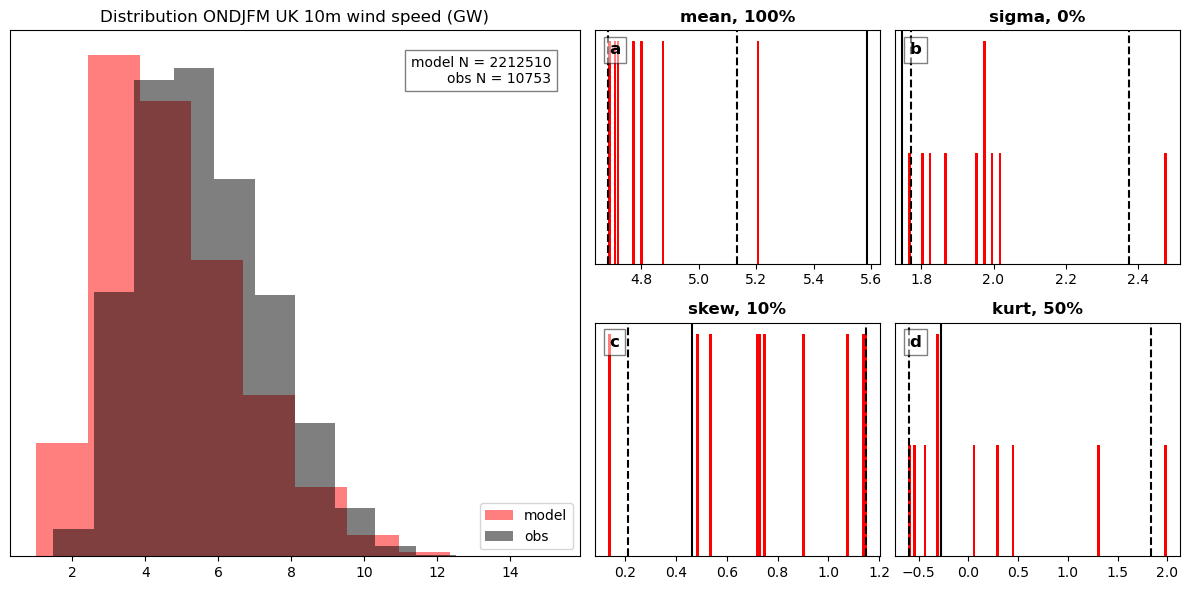

In [7]:
# plot the distributions of 10m wind speed
plot_distributions_fidelity(
    obs_df=df_obs_sfcWind,
    model_df=df_model_sfcWind,
    obs_val_name="10m_wind_speed",
    model_val_name="data",
    obs_time_name="date",
    model_time_name="init_year",
    model_member_name="member",
    model_lead_name="lead",
    title="Distribution ONDJFM UK 10m wind speed (GW)",
    nboot=10,
    figsize=(12, 6),
    fname_prefix="UK_wind_speed_ondjfm_distribution_fidelity_1960-2018",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

Now fit the sigmoid

In [8]:
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score

In [9]:
# Set up the sigmoid fit
def sigmoid(x, L, x0, k, b):
    """
    Computes the sigmoid function.

    Parameters:
    x (float or array-like): The input value(s) for which to compute the sigmoid function.
    L (float): The curve's maximum value.
    x0 (float): The x-value of the sigmoid's midpoint.
    k (float): The steepness of the curve.
    b (float): The value to shift the curve vertically.

    Returns:
    float or array-like: The computed sigmoid value(s).
    """
    y = L / (1 + np.exp(-k * (x - x0))) + b
    return y

# include an initial guess for the parameters based on the obs data
p0 = [max(df_obs_sfcWind['wind_gen']), np.median(df_obs_sfcWind['10m_wind_speed']), 1, min(df_obs_sfcWind['wind_gen'])]

# fit the sigmoid function to the data
popt, pcov = curve_fit(sigmoid, df_obs_sfcWind['10m_wind_speed'], df_obs_sfcWind['wind_gen'], p0=p0, method='dogbox')

/tmp/ipykernel_1336666/938417674.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(x, sigmoid(x, *popt), 'r-', label='fit: L=%5.3f, x0=%5.3f, k=%5.3f, b=%5.3f' % tuple(popt), color='orange')


Text(0.5, 1.0, 'Wind generation vs 10m wind speed (UK, 1960-2018)')

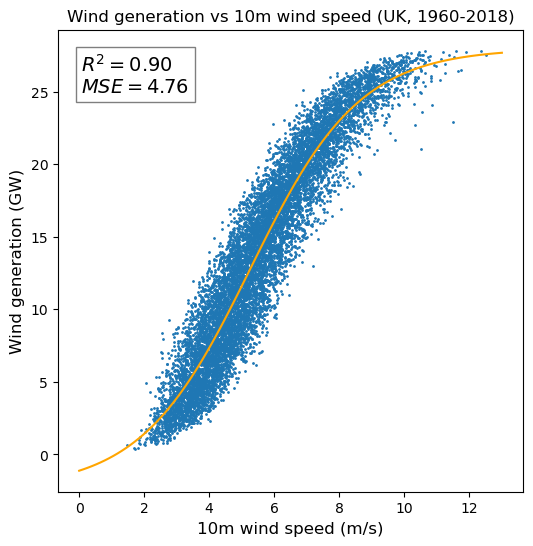

In [10]:
# plot the sigmoid fit
# Set up a figure
fig, ax = plt.subplots(figsize=(6, 6))

# plot the scatter of the data
ax.scatter(df_obs_sfcWind['10m_wind_speed'], df_obs_sfcWind['wind_gen'], s=1)

# plot the sigmoid fit
x = np.linspace(0, round(max(df_obs_sfcWind['10m_wind_speed'])), 100)

ax.plot(x, sigmoid(x, *popt), 'r-', label='fit: L=%5.3f, x0=%5.3f, k=%5.3f, b=%5.3f' % tuple(popt), color='orange')

# calculte the r2 value
r2 = r2_score(df_obs_sfcWind['wind_gen'], sigmoid(df_obs_sfcWind['10m_wind_speed'], *popt))

# calculate the mean squared error
mse = mean_squared_error(df_obs_sfcWind['wind_gen'], sigmoid(df_obs_sfcWind['10m_wind_speed'], *popt))

# include these values in a textbox in the top left
textstr = '\n'.join((
    r'$R^2=%.2f$' % (r2, ),
    r'$MSE=%.2f$' % (mse, )))

ax.text(
    0.05,
    0.95,
    textstr,
    transform=ax.transAxes,
    fontsize=14,
    verticalalignment='top',
    horizontalalignment='left',
    bbox=dict(facecolor='white', alpha=0.5)
)

# set the labels
ax.set_xlabel('10m wind speed (m/s)', fontsize=12)

ax.set_ylabel('Wind generation (GW)', fontsize=12)

# set the title
ax.set_title('Wind generation vs 10m wind speed (UK, 1960-2018)')

In [11]:
# bias correct the wind speed data
bias = df_obs_sfcWind['10m_wind_speed'].mean() - df_model_sfcWind['data'].mean()

# bias correct
df_model_sfcWind['10m_wind_speed_bc'] = df_model_sfcWind['data'] + bias

In [12]:
# Derive the wind generation for the model data
df_model_sfcWind['wind_gen_sigmoid'] = sigmoid(df_model_sfcWind['data'], *popt)

In [13]:
df_model_sfcWind['wind_gen_sigmoid_bc'] = sigmoid(df_model_sfcWind['10m_wind_speed_bc'], *popt)

In [14]:
# same for the obs data
df_obs_sfcWind['wind_gen_sigmoid'] = sigmoid(df_obs_sfcWind['10m_wind_speed'], *popt)

In [15]:
df_model_sfcWind.head()

,init_year,member,lead,data,10m_wind_speed_bc,wind_gen_sigmoid,wind_gen_sigmoid_bc
0,1960,1,1,8.429288,9.279450,23.962343,25.419453
1,1960,1,2,9.267500,10.117662,25.402797,26.368019
2,1960,1,3,7.539931,8.390093,21.741177,23.880540
3,1960,1,4,7.504783,8.354944,21.637025,23.805987
4,1960,1,5,5.574239,6.424400,14.190453,17.833808


(array([  9.,  68., 183., 304., 393., 431., 472., 471., 508., 497., 481.,
        521., 464., 453., 446., 457., 419., 432., 399., 398., 372., 400.,
        361., 408., 353., 308., 295., 250., 160.,  40.]),
 array([ 0.49854974,  1.40094851,  2.30334729,  3.20574607,  4.10814484,
         5.01054362,  5.91294239,  6.81534117,  7.71773994,  8.62013872,
         9.5225375 , 10.42493627, 11.32733505, 12.22973382, 13.1321326 ,
        14.03453138, 14.93693015, 15.83932893, 16.7417277 , 17.64412648,
        18.54652525, 19.44892403, 20.35132281, 21.25372158, 22.15612036,
        23.05851913, 23.96091791, 24.86331668, 25.76571546, 26.66811424,
        27.57051301]),
 <BarContainer object of 30 artists>)

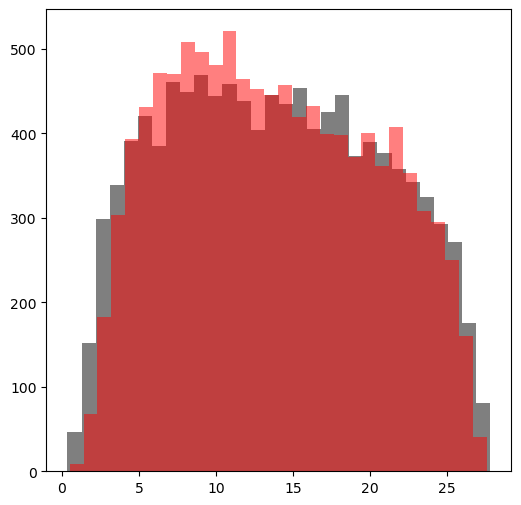

In [16]:
# set up a figure
fig, ax = plt.subplots(figsize=(6, 6))

# plot the histogram of the obs data wind gen
ax.hist(df_obs_sfcWind['wind_gen'], bins=30, alpha=0.5, color='k', label='obs')

# plot the histogram of the obs data wind gen
ax.hist(df_obs_sfcWind["wind_gen_sigmoid"], bins=30, alpha=0.5, color='red', label='sigmoid model')

Calculating bootstrap statistics:   0%|          | 0/10 [00:00<?, ?it/s]

Calculating bootstrap statistics: 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


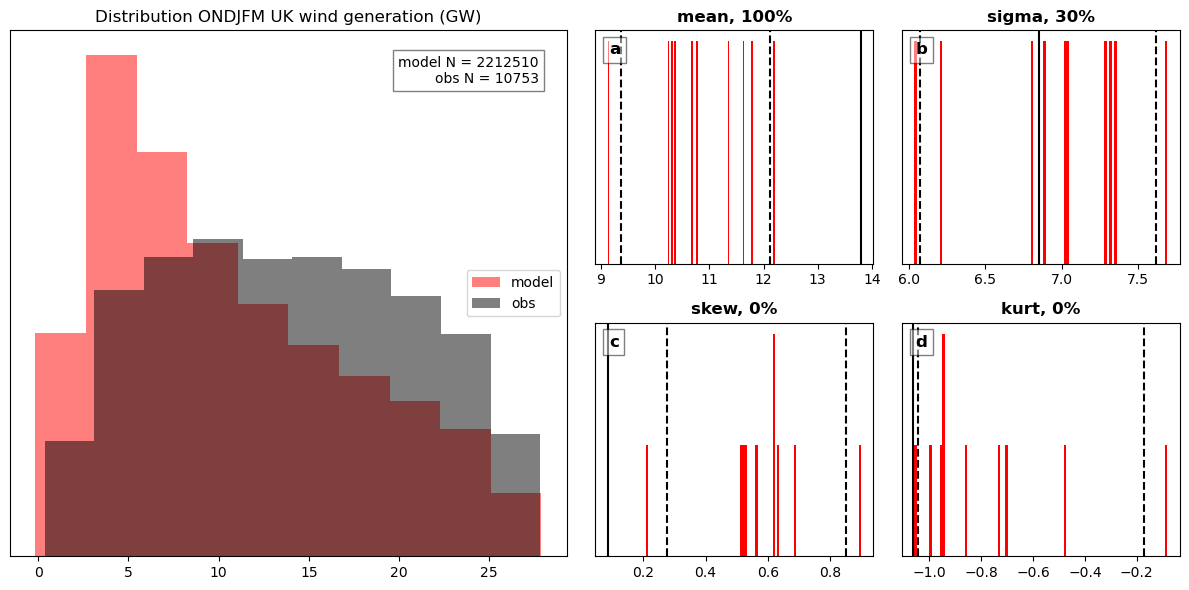

In [17]:
# compare the wind generation from the model and the obs
plot_distributions_fidelity(
    obs_df=df_obs_sfcWind,
    model_df=df_model_sfcWind,
    obs_val_name="wind_gen",
    model_val_name="wind_gen_sigmoid",
    obs_time_name="date",
    model_time_name="init_year",
    model_member_name="member",
    model_lead_name="lead",
    title="Distribution ONDJFM UK wind generation (GW)",
    nboot=10,
    figsize=(12, 6),
    fname_prefix="UK_wind_generation_ondjfm_distribution_fidelity_1960-2018",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

Calculating bootstrap statistics:   0%|          | 0/10 [00:00<?, ?it/s]

Calculating bootstrap statistics: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


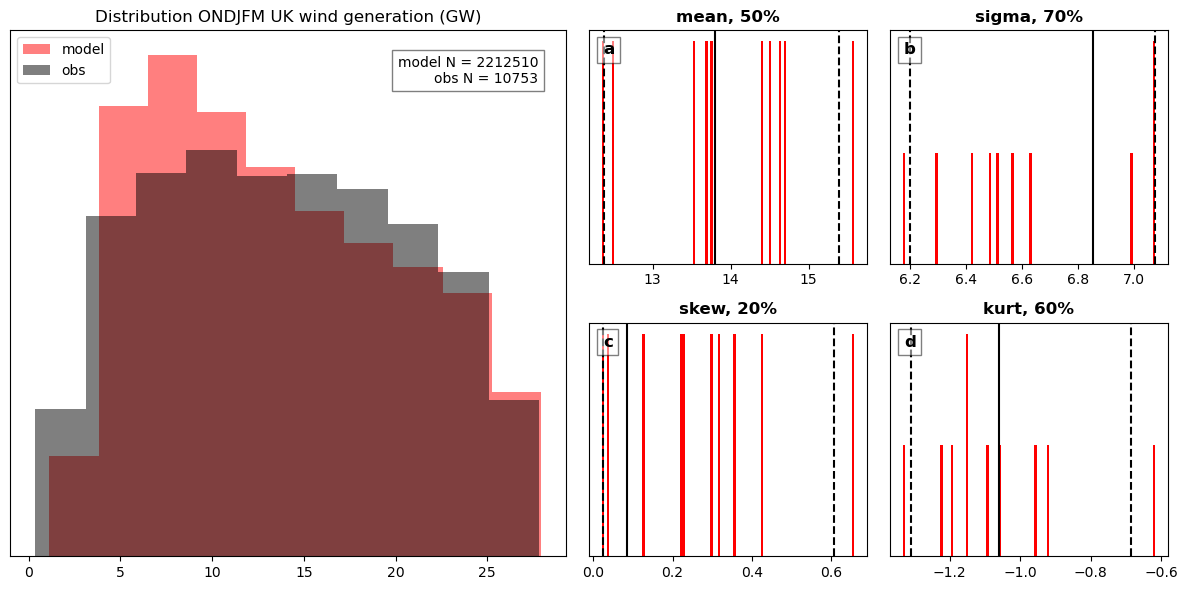

In [18]:
# compare the wind generation from the model and the obs
plot_distributions_fidelity(
    obs_df=df_obs_sfcWind,
    model_df=df_model_sfcWind,
    obs_val_name="wind_gen",
    model_val_name="wind_gen_sigmoid_bc",
    obs_time_name="date",
    model_time_name="init_year",
    model_member_name="member",
    model_lead_name="lead",
    title="Distribution ONDJFM UK wind generation (GW)",
    nboot=10,
    figsize=(12, 6),
    fname_prefix="UK_wind_generation_ondjfm_distribution_fidelity_1960-2018",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

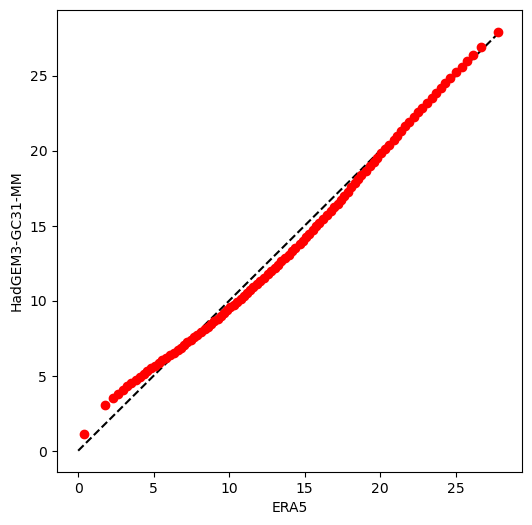

In [19]:
# plot the qq of the wind generation
plot_qq(
    obs_df=df_obs_sfcWind,
    model_df=df_model_sfcWind,
    obs_val_name="wind_gen",
    model_val_name="wind_gen_sigmoid_bc",
    save_prefix="UK_wind_generation_ondjfm_qq_1960-2018",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

The ks stat is 0.03979303630120018
The ks p is 3.685436197046935e-15
at alpha = 0.05, the critical value is 0.013147006708607733
at alpha = 0.01, the critical value is 0.015757074216934265
The null hypothesis is rejected at the 1% level
The two samples are not drawn from the same distribution
The null hypothesis is rejected at the 1% level
The two samples are not drawn from the same distribution


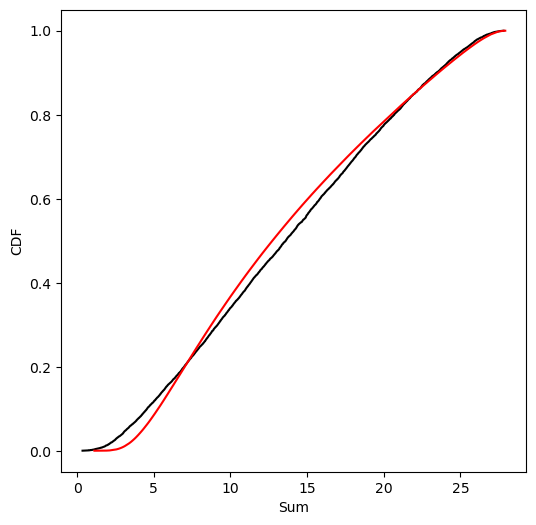

In [20]:
# Plot the cdffs
plot_cdfs(
    obs_df=df_obs_sfcWind,
    model_df=df_model_sfcWind,
    obs_val_name="wind_gen",
    model_val_name="wind_gen_sigmoid_bc",
    save_prefix="UK_wind_generation_ondjfm_cdf_1960-2018",
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

Now quantify, for the observations and model data:

* The no. exceedance days (where wind power beenath 8th percentile of obs)
* The severity (each instance multiplied by the distance beneath the threshold)

In [21]:
# if the index is not A DATETIME, THEN set date as the index
if not isinstance(df_obs_sfcWind.index, pd.DatetimeIndex):
    df_obs_sfcWind["date"] = pd.to_datetime(df_obs_sfcWind["date"])
    df_obs_sfcWind.set_index("date", inplace=True)

In [22]:
# Therefore use the 92th percentile for exceedance
# loop over the winter years
winter_years = np.arange(1960, 2018 + 1)

# Set up an array to store the severity index
severity_index = np.zeros(len(winter_years))

# Set up an array to store the no. exceedance days
no_exceedance_days = np.zeros(len(winter_years))

# Set up an empty list for the dates
dates_exceedance_values = []
exceedance_values = []
winter_mean_dnw = []

all_winters_92 = np.percentile(df_obs_sfcWind["wind_gen"], 20)

# loop over the winter years
for i, year in enumerate(winter_years):
    # Set up the first and last day of the winter
    winter_start = pd.Timestamp(f"{year}-10-01")
    winter_end = pd.Timestamp(f"{year+1}-03-31")

    # subset the data
    df = df_obs_sfcWind.loc[winter_start:winter_end]

    # if df includes 29th feb, then drop this row
    if f"{year + 1}-02-29" in df.index:
        print("Dropping 29th Feb")
        df = df.drop(pd.Timestamp(f"{year + 1}-02-29"))

    # apply a boolean mask to the demand net wind value
    # which is true where the demand net wind is greater than the 80% tile value
    mask = df["wind_gen"] < all_winters_92

    # # plot the data as a grey line
    # ax.plot(index_date, df["UK_demand"], color="grey", alpha=0.2)

    # # plot the masked values as red dots
    # ax.plot(index_date[mask], df["UK_demand"][mask], "rx")

    # calculate the severity index
    severity_index[i] = (all_winters_92 - df["wind_gen"][mask]).sum()

    # calculate the no. exceedance days
    no_exceedance_days[i] = mask.sum()

    # calculate the mean demand net wind for the winter
    winter_mean_dnw.append(df["wind_gen"].mean())

    # format the dates to yyyy-mm-dd
    dates = df.index[mask].strftime("%Y-%m-%d")

    # Add the dates and values to the list
    dates_exceedance_values.extend(df.index[mask])

    # Add the exceedance values to the list
    exceedance_values.extend(df["wind_gen"][mask])

# set up a dataframe for the number of exceedance days
df_exceedance_days_obs = pd.DataFrame(
    {
        "severity": severity_index,
        "no_exceedance_days": no_exceedance_days,
        "winter_mean_wind_gen": winter_mean_dnw,
    },
    index=winter_years,
)

Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb


Now process the model data in the same way

In [23]:
# subset the model to the correct years
winter_years = np.arange(1, 10 + 1)

# set up a new df to append to
df_model_ondjfm_wyear = pd.DataFrame()

# Loop over the winter years
for i, wyear in enumerate(winter_years):
    # Set up the leads to extract
    leads = np.arange(331 + (i * 360), 331 + 180 + (i * 360))

    # Extract the data
    df_model_leads_this = df_model_sfcWind[df_model_sfcWind["lead"].isin(leads)]

    # include a new column containing the winter year
    df_model_leads_this["winter_year"] = wyear

    # Append to the new df
    df_model_ondjfm_wyear = pd.concat([df_model_ondjfm_wyear, df_model_leads_this])

/tmp/ipykernel_1336666/1207909311.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_leads_this["winter_year"] = wyear
/tmp/ipykernel_1336666/1207909311.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_leads_this["winter_year"] = wyear
/tmp/ipykernel_1336666/1207909311.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [24]:
# Extract the unique init years
init_years = df_model_ondjfm_wyear["init_year"].unique()
members = df_model_ondjfm_wyear["member"].unique()
winter_years = df_model_ondjfm_wyear["winter_year"].unique()

# Set up an array to store the severity index
model_severity_index = np.zeros([len(init_years), len(members), len(winter_years)])
model_no_exceedance_days = np.zeros([len(init_years), len(members), len(winter_years)])

# Set up an empty list for the dates
model_dates_exceedance_values = []
model_exceedance_values = []
winter_mean_dnw = []

# Set up an empty df
df_model_exceedance = pd.DataFrame()

# loop over the init years
for i, i_year in enumerate(init_years):
    for j, member in enumerate(members):
        for k, w_year in enumerate(winter_years):
            # Constrain to the init year, member and winter year
            df_this = df_model_ondjfm_wyear[
                (df_model_ondjfm_wyear["init_year"] == i_year)
                & (df_model_ondjfm_wyear["member"] == member)
                & (df_model_ondjfm_wyear["winter_year"] == w_year)
            ]

            # apply a boolean mask to the demand net wind value
            # which is true where the demand net wind is greater than the 80% tile value
            mask = df_this["wind_gen_sigmoid_bc"] < all_winters_92

            # calculate the severity index
            model_severity_index[i, j, k] = (all_winters_92 - df_this["wind_gen_sigmoid_bc"][mask]).sum()

            # calculate the no. exceedance days
            model_no_exceedance_days[i, j, k] = mask.sum()

            # # winter mean values
            # winter_mean_dnw.append(df_this["wd_demand_net_wind_pred_bc"].mean())

            # Set up the df
            df_this_exceedance = pd.DataFrame(
                {
                    "init_year": [i_year],
                    "member": [member],
                    "winter_year": [w_year],
                    "severity": [model_severity_index[i, j, k]],
                    "no_exceedance_days": [model_no_exceedance_days[i, j, k]],
                }
            )

            # Append to the df
            df_model_exceedance = pd.concat([df_model_exceedance, df_this_exceedance])

In [25]:
# create a new column in df_model_exceedance
# effective dec_year
df_model_exceedance["effective_dec_year"] = df_model_exceedance["init_year"] + df_model_exceedance["winter_year"]

Observed trend: [-1.19696084e-01  2.74194155e+02]
Model trend: [ 7.45700200e-02 -1.20773295e+02]


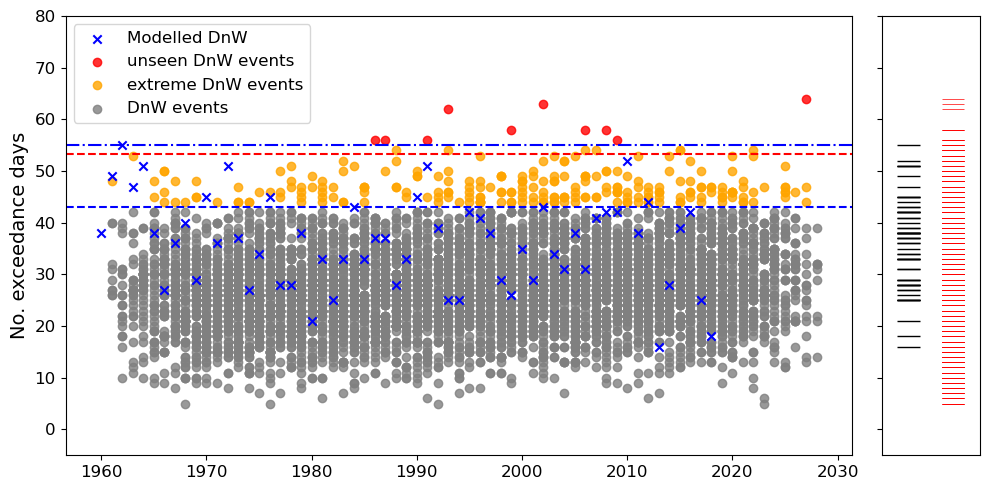

In [26]:
import seaborn as sns

# Set up the figure
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10, 5),
    sharey=True,
    gridspec_kw={"width_ratios": [8, 1]},
)

# add a horizontal line for the 0.8 quantile of the observations
axs[0].axhline(
    np.quantile(df_exceedance_days_obs["no_exceedance_days"], 0.8),
    color="blue",
    linestyle="--",
)

# red line for 99th percentile of the obs
axs[0].axhline(
    np.quantile(df_exceedance_days_obs["no_exceedance_days"], 0.99),
    color="red",
    linestyle="--",
)

# for the max value of the obs
axs[0].axhline(
    np.max(df_exceedance_days_obs["no_exceedance_days"]),
    color="blue",
    linestyle="-.",
)

# plot the scatter points for the obs
axs[0].scatter(
    df_exceedance_days_obs.index,
    df_exceedance_days_obs["no_exceedance_days"],
    color="blue",
    marker="x",
    label="Modelled DnW",
    zorder=2,
)

# Plot a blue sahsed trend line for the obs
obs_trend = np.polyfit(df_exceedance_days_obs.index, df_exceedance_days_obs["no_exceedance_days"], 1)

# Separate model data by threshold
very_bad_events = df_model_exceedance[
    df_model_exceedance["no_exceedance_days"] > np.max(df_exceedance_days_obs["no_exceedance_days"])
]

# Model data above 80th percentile
bad_events = df_model_exceedance[
    (df_model_exceedance["no_exceedance_days"] > np.quantile(df_exceedance_days_obs["no_exceedance_days"], 0.8)) &
    (df_model_exceedance["no_exceedance_days"] < np.max(df_exceedance_days_obs["no_exceedance_days"]))
]

# Model data below 80th percentile
events = df_model_exceedance[
    df_model_exceedance["no_exceedance_days"] < np.quantile(df_exceedance_days_obs["no_exceedance_days"], 0.8)
]

# Plot the points below the minimum of the obs
axs[0].scatter(
    very_bad_events["effective_dec_year"],
    very_bad_events["no_exceedance_days"],
    color="red",
    alpha=0.8,
    label="unseen DnW events",
)

# Plot the points below the 20th percentile
axs[0].scatter(
    bad_events["effective_dec_year"],
    bad_events["no_exceedance_days"],
    color="orange",
    alpha=0.8,
    label="extreme DnW events",
)

# Plot the points above the 20th percentile
axs[0].scatter(
    events["effective_dec_year"],
    events["no_exceedance_days"],
    color="grey",
    alpha=0.8,
    label="DnW events",
)

# qunatify the linear trend for the model data
model_trend = np.polyfit(df_model_exceedance["effective_dec_year"], df_model_exceedance["no_exceedance_days"], 1)

# print the trends
print(f"Observed trend: {obs_trend}")
print(f"Model trend: {model_trend}")

# # plot the linear trend for the obs data as a dahsed blue line
# axs[0].plot(
#     df_exceedance_days_obs.index,
#     obs_trend[0] * df_exceedance_days_obs.index + obs_trend[1],
#     color="k",
#     linestyle="--",
#     label="Observed trend",
# )

# # plot the linear trend for the model data as a dahsed red line
# axs[0].plot(
#     df_model_exceedance["effective_dec_year"],
#     model_trend[0] * df_model_exceedance["effective_dec_year"] + model_trend[1],
#     color="red",
#     linestyle="--",
#     label="Model trend",
# )

# # for the most extreme evnts
# # plot the error bars
# axs[0].errorbar(
#     very_bad_events["effective_dec_year"],
#     very_bad_events["no_exceedance_days"],
#     yerr=[
#         very_bad_events["no_exceedance_days"] - very_bad_events["no_exceedance_days_05"],  # lower errors
#         very_bad_events["no_exceedance_days_95"] - very_bad_events["no_exceedance_days"],  # upper errors
#     ],
#     fmt="none",
#     ecolor="red",
#     capsize=5,
#     zorder=1,
# )

# include the legend
axs[0].legend(fontsize=12)

# label the y-axis
axs[0].set_ylabel("No. exceedance days", fontsize=14)

# set up the x-axis

# increase the size of the value labels
axs[0].tick_params(axis="x", labelsize=12)

# same for the y-axis
axs[0].tick_params(axis="y", labelsize=12)

# set up the ylims
axs[0].set_ylim(-5, 80)

# do the events plots for the no. exceedance days on the second plot
axs[1].eventplot(
    df_exceedance_days_obs["no_exceedance_days"],
    colors="black",
    lineoffsets=0,
    linelengths=0.5,
    orientation="vertical",
    linewidths=1,
    label="Observed",
)

# plot the model data
axs[1].eventplot(
    df_model_exceedance["no_exceedance_days"],
    colors="red",
    lineoffsets=1,
    linelengths=0.5,
    orientation="vertical",
    linewidths=0.5,
    label="Model",
)

# # set up the xlabels for the second plot
# xlabels = ["Observed", "Model"]

# # add the xlabels to the second subplot
# axs[1].set_xticks(xlabels)

# # remove the xlabel
# axs[1].set_xlabel("")

# # remove the yticks and axis lin
# axs[1].set_yticks([])

# remove the xticks from the second plot
axs[1].set_xticks([])

# specify a tight layout
plt.tight_layout()

# set up a fname for the plot
fname = "no_exceedance_days_uk_wind_generation_1960-2018"

save_dir = "/home/users/benhutch/unseen_multi_year/plots"

# form the savepath
savepath = os.path.join(save_dir, fname)

if not os.path.exists(savepath):
    # save the plot
    plt.savefig(savepath, bbox_inches="tight", dpi=800)

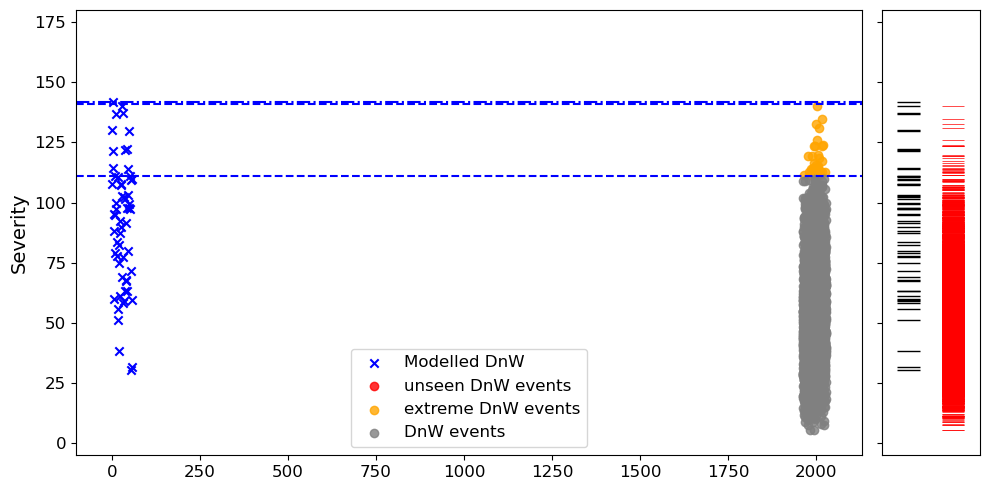

In [34]:
# Same but for severity index
import seaborn as sns

# Set up the figure
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10, 5),
    sharey=True,
    gridspec_kw={"width_ratios": [8, 1]},
)

# add a horizontal line for the 0.8 quantile of the observations
axs[0].axhline(
    np.quantile(df_exceedance_days_obs["severity"], 0.8),
    color="blue",
    linestyle="--",
)

# for the max value of the obs
axs[0].axhline(
    np.max(df_exceedance_days_obs["severity"]),
    color="blue",
    linestyle="-.",
)

# plot the scatter points for the obs
axs[0].scatter(
    df_exceedance_days_obs.index,
    df_exceedance_days_obs["severity"],
    color="blue",
    marker="x",
    label="Modelled DnW",
    zorder=2,
)

# Separate model data by threshold
very_bad_events = df_model_exceedance[
    df_model_exceedance["severity"] > np.max(df_exceedance_days_obs["severity"])
]

# Model data above 80th percentile
bad_events = df_model_exceedance[
    (df_model_exceedance["severity"] > np.quantile(df_exceedance_days_obs["severity"], 0.8)) &
    (df_model_exceedance["severity"] < np.max(df_exceedance_days_obs["severity"]))
]

# Model data below 80th percentile
events = df_model_exceedance[
    df_model_exceedance["severity"] < np.quantile(df_exceedance_days_obs["severity"], 0.8)
]

# Plot the points below the minimum of the obs
axs[0].scatter(
    very_bad_events["effective_dec_year"],
    very_bad_events["severity"],
    color="red",
    alpha=0.8,
    label="unseen DnW events",
)

# Plot the points below the 20th percentile
axs[0].scatter(
    bad_events["effective_dec_year"],
    bad_events["severity"],
    color="orange",
    alpha=0.8,
    label="extreme DnW events",
)

# Plot the points above the 20th percentile
axs[0].scatter(
    events["effective_dec_year"],
    events["severity"],
    color="grey",
    alpha=0.8,
    label="DnW events",
)

# Quantify the linear trend for th observations
obs_trend = np.polyfit(df_exceedance_days_obs.index, df_exceedance_days_obs["severity"], 1)

# Quantify the linear trend for the model data
model_trend = np.polyfit(df_model_exceedance["effective_dec_year"], df_model_exceedance["severity"], 1)

# # plot the linear trend for the obs data as a dahsed black line
# axs[0].plot(
#     df_exceedance_days_obs.index,
#     obs_trend[0] * df_exceedance_days_obs.index + obs_trend[1],
#     color="k",
#     linestyle="--",
#     label="Observed trend",
# )

# # plot the linear trend for the model data as a dahsed red line
# axs[0].plot(
#     df_model_exceedance["effective_dec_year"],
#     model_trend[0] * df_model_exceedance["effective_dec_year"] + model_trend[1],
#     color="red",
#     linestyle="--",
#     label="Model trend",
# )

# for the most extreme evnts
# # plot the error bars
# axs[0].errorbar(
#     very_bad_events["effective_dec_year"],
#     very_bad_events["severity"],
#     yerr=[
#         very_bad_events["severity"] - very_bad_events["severity_05"],  # lower errors
#         very_bad_events["severity_95"] - very_bad_events["severity"],  # upper errors
#     ],
#     fmt="none",
#     ecolor="red",
#     capsize=5,
#     zorder=1,
# )

# include the legend
axs[0].legend(fontsize=12)

# label the y-axis
axs[0].set_ylabel("Severity", fontsize=14)

# set up the x-axis

# increase the size of the value labels
axs[0].tick_params(axis="x", labelsize=12)

# same for the y-axis
axs[0].tick_params(axis="y", labelsize=12)

# set up the ylims
axs[0].set_ylim(-5, 180)

# do the events plots for the no. exceedance days on the second plot
axs[1].eventplot(
    df_exceedance_days_obs["severity"],
    colors="black",
    lineoffsets=0,
    linelengths=0.5,
    orientation="vertical",
    linewidths=1,
    label="Observed",
)

# plot the model data
axs[1].eventplot(
    df_model_exceedance["severity"],
    colors="red",
    lineoffsets=1,
    linelengths=0.5,
    orientation="vertical",
    linewidths=0.5,
    label="Model",
)

# horizontal red line for the 99th precentile of the obs
axs[0].axhline(
    np.quantile(df_exceedance_days_obs["severity"], 0.99),
    color="blue",
    linestyle="--",
)

# # set up the xlabels for the second plot
# xlabels = ["Observed", "Model"]

# # add the xlabels to the second subplot
# axs[1].set_xticks(xlabels)

# # remove the xlabel
# axs[1].set_xlabel("")

# # remove the yticks and axis lin
# axs[1].set_yticks([])

# remove the xticks from the second plot
axs[1].set_xticks([])

# specify a tight layout
plt.tight_layout()

# set up a fname for the plot
fname = "severity_uk_wind_gen_1960-2018.pdf"

save_dir = "/home/users/benhutch/unseen_multi_year/plots"

# form the savepath
savepath = os.path.join(save_dir, fname)

if not os.path.exists(savepath):
    # save the plot
    plt.savefig(savepath, bbox_inches="tight", dpi=800)


Now plot the return period for these extremes

In [29]:
sys.path.append("/home/users/benhutch/unseen_functions")
from functions import plot_rp_extremes

In [30]:
# if there is no column named "index"
if "index" not in df_exceedance_days_obs.columns:
    # reset the index
    df_exceedance_days_obs.reset_index(inplace=True)

In [31]:
# do the same for the model data
df_model_exceedance["effective_dec_year_dt"] = pd.to_datetime(df_model_exceedance["effective_dec_year"], format="%Y")

In [32]:
df_exceedance_days_obs.head()

,index,severity,no_exceedance_days,winter_mean_wind_gen
0,1960,107.566085,38.0,13.009050
1,1961,130.321017,49.0,13.457975
2,1962,141.909612,55.0,11.647347
3,1963,114.316431,47.0,12.396667
4,1964,121.332698,51.0,12.111368


In [33]:
# format the int column containing 1960, 1961 etc
# as datetime in years
df_exceedance_days_obs["index_dt"] = pd.to_datetime(df_exceedance_days_obs["index"], format="%Y")

In [ ]:
# print the 99th percenti

   index    severity  no_exceedance_days  winter_mean_wind_gen   index_dt
0   1960  107.566085                38.0             13.009050 1960-01-01
1   1961  130.321017                49.0             13.457975 1961-01-01
2   1962  141.909612                55.0             11.647347 1962-01-01
3   1963  114.316431                47.0             12.396667 1963-01-01
4   1964  121.332698                51.0             12.111368 1964-01-01
    index    severity  no_exceedance_days  winter_mean_wind_gen   index_dt
54   2014   71.680773                28.0             14.693515 2014-01-01
55   2015  109.262406                39.0             14.606173 2015-01-01
56   2016  109.870273                42.0             12.180066 2016-01-01
57   2017   59.570081                25.0             14.461741 2017-01-01
58   2018   31.632250                18.0             13.919720 2018-01-01
   init_year  member  winter_year   severity  no_exceedance_days  \
0       1960       1            1  78.

100%|██████████| 1000/1000 [02:26<00:00,  6.84it/s]


Model estimate for obs 99th %tile event: 99.67139671009976
Model estimate for obs 99th %tile event 2.5th percentile: 99.65034541787905
Model estimate for obs 99th %tile event 97.5th percentile: 99.72145584017186
Return period for obs 99th %tile event: 304.31831656450584
Return period for obs 99th %tile event 2.5th percentile: 285.9965380502536
Return period for obs 99th %tile event 97.5th percentile: 359.0095016233638
CPU times: user 2min 26s, sys: 274 ms, total: 2min 26s
Wall time: 2min 27s


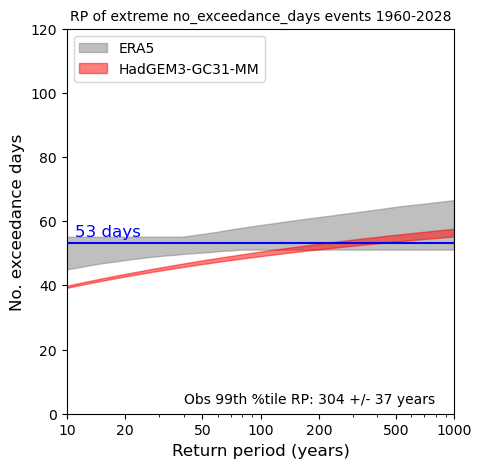

In [67]:
%%time

# Now test the function which does the same
plot_rp_extremes(
    obs_df=df_exceedance_days_obs,
    model_df=df_model_exceedance,
    obs_val_name="no_exceedance_days",
    model_val_name="no_exceedance_days",
    obs_time_name="index_dt",
    model_time_name="effective_dec_year_dt",
    # years_period=(1960, 1990), # first half
)

In [68]:
%%time

from scipy.stats import genextreme as gev

num_samples = 1000

decades = np.arange(1960, 2030, 10)

decade_years = []

# Set up the decade years
for i, decade in enumerate(decades):
    if i == 0:
        decade_years.append(np.arange(decade, decade + 11))
    else:
        decade_years.append(np.arange(decade + 1, decade + 11))

# Flatten the list of arrays into a single list
flattened_years = np.concatenate(decade_years)

# Filter out the years not in df_model_exceedance["effective_dec_year"].unique()
filtered_years = [year for year in flattened_years if year in df_model_exceedance["effective_dec_year"].unique()]

# Reshape the filtered list back into the original decade structure
filtered_decade_years = []
for i, decade in enumerate(decades):
    if i == 0:
        filtered_decade_years.append(np.array([year for year in filtered_years if 1960 <= year <= 1970]))
    else:
        filtered_decade_years.append(np.array([year for year in filtered_years if decade + 1 <= year <= decade + 10]))

# try the same but with the empirical return levels
# extract the unique winter years from the model df
unique_winter_years = df_model_exceedance["effective_dec_year"].unique()

# find the year of the highest value for no exceedance days
# in the observed data
# Assuming df_exceedance_days_obs is your DataFrame
max_year = df_exceedance_days_obs.loc[
    df_exceedance_days_obs["no_exceedance_days"].idxmax()
].name

# Print the max year
print("The year with the greatest no. exceedance days is: ", max_year)
print("The value is: ", df_exceedance_days_obs["no_exceedance_days"].max())

# set up params year
decade_params = np.zeros([len(filtered_decade_years), num_samples, 3])

# Loop over the unique winter years
for i, decade in tqdm(enumerate(filtered_decade_years)):
    # Subset the model data to the decade years
    df_model_exceedance_this = df_model_exceedance[
        df_model_exceedance["effective_dec_year"].isin(decade)
    ]

    # initialise the list of params
    params_decade = np.zeros([num_samples, 3])

    # Loop over the samples
    for j in range(num_samples):
        params_decade[j, :] = gev.fit(
            np.random.choice(
                df_model_exceedance_this["no_exceedance_days"],
                size=len(df_model_exceedance_this),
                replace=True,
            )
        )

    # append the params to the model year
    decade_params[i, :, :] = params_decade

The year with the greatest no. exceedance days is:  2
The value is:  55.0


7it [05:52, 50.31s/it]

CPU times: user 5min 50s, sys: 22.1 ms, total: 5min 50s
Wall time: 5min 52s


In [69]:
sys.path.append("/home/users/benhutch/unseen_functions")
from functions import estimate_period

In [70]:
# Set up the array for mean, 2.5th and 97.5th percentiles
period_decade_mean = np.zeros([len(filtered_decade_years)])
period_decade_025 = np.zeros([len(filtered_decade_years)])
period_decade_975 = np.zeros([len(filtered_decade_years)])

# find the value for the observed worst event
obs_worst_event = df_exceedance_days_obs["no_exceedance_days"].max()

# find the value for the obs 99th percentile event
obs_99_event = np.percentile(df_exceedance_days_obs["no_exceedance_days"], 99)

# loop over the unique years to fit the ppfs
for i, decade in tqdm(enumerate(filtered_decade_years)):
    # Subset the params for the decade
    params_decade = decade_params[i, :, :]

    # Estimate the period for the model mean data
    period_decade_mean[i] = estimate_period(
        return_level=obs_99_event,
        loc=np.mean(params_decade[:, 1]),
        scale=np.mean(params_decade[:, 2]),
        shape=np.mean(params_decade[:, 0]),
    )

    # model 025 percentile
    period_decade_025[i] = estimate_period(
        return_level=obs_99_event,
        loc=np.percentile(params_decade[:, 1], 2.5),
        scale=np.percentile(params_decade[:, 2], 2.5),
        shape=np.percentile(params_decade[:, 0], 2.5),
    )

    # model 95 percentile
    period_decade_975[i] = estimate_period(
        return_level=obs_99_event,
        loc=np.percentile(params_decade[:, 1], 97.5),
        scale=np.percentile(params_decade[:, 2], 97.5),
        shape=np.percentile(params_decade[:, 0], 97.5),
    )

# put these into a dataframe with the years
model_df_rl = pd.DataFrame(
    {
        "decade": decades,
        "mean": period_decade_mean,
        "025": period_decade_025,
        "975": period_decade_975,
    }
)

7it [00:00, 1282.77it/s]


In [71]:
# for each row of "mean", "025", "975" calculate the return period
# 1 / (1 - (100 - value))
model_df_rl["mean_rp (%)"] = 1 - (model_df_rl["mean"] / 100)
model_df_rl["025_rp (%)"] = 1 - (model_df_rl["025"] / 100)
model_df_rl["975_rp (%)"] = 1 - (model_df_rl["975"] / 100)

# calculate the return period in years of the observed worst event
model_df_rl["mean_rp (years)"] = 1 / model_df_rl["mean_rp (%)"]
model_df_rl["025_rp (years)"] = 1 / model_df_rl["025_rp (%)"]
model_df_rl["975_rp (years)"] = 1 / model_df_rl["975_rp (%)"]

In [73]:
model_df_rl

,decade,mean,025,975,mean_rp (%),025_rp (%),975_rp (%),mean_rp (years),025_rp (years),975_rp (years)
0,1960,100.000000,99.992411,100.000000,0.000000,0.000076,0.000000,inf,1.317662e+04,inf
1,1970,99.939919,99.899391,99.975782,0.000601,0.001006,0.000242,1664.423561,9.939490e+02,4129.088997
2,1980,99.839472,99.792115,99.888187,0.001605,0.002079,0.001118,622.943395,4.810361e+02,894.351692
3,1990,99.593398,99.524723,99.733254,0.004066,0.004753,0.002667,245.940967,2.104037e+02,374.888604
4,2000,99.366689,99.293982,99.480633,0.006333,0.007060,0.005194,157.900219,1.416394e+02,192.542196
5,2010,99.689139,99.638063,99.735092,0.003109,0.003619,0.002649,321.687034,2.762910e+02,377.488892
6,2020,100.000000,100.000000,22.583543,0.000000,0.000000,0.774165,inf,inf,1.291715


ValueError: 'yerr' must not contain negative values

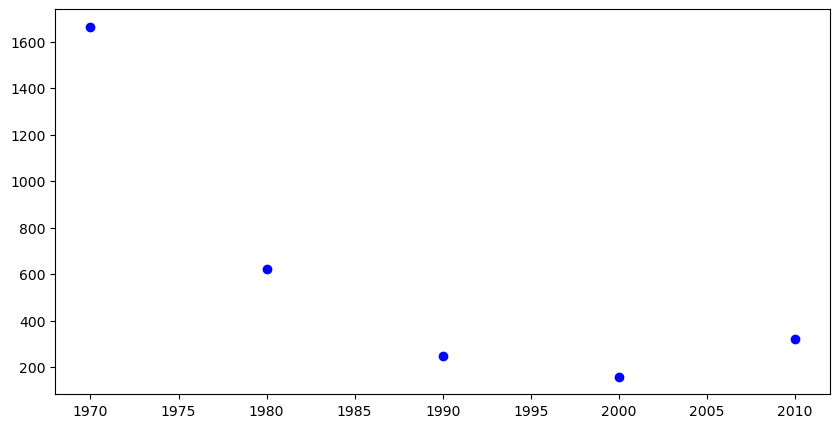

In [72]:
# plot the mean rp values with error bars for the 025 and 975 percentiles
plt.figure(figsize=(10, 5))

# plot the mean
plt.scatter(
    model_df_rl["decade"],
    model_df_rl["mean_rp (years)"],
    color="blue",
    label="Mean",
)

# plot the 025 and 975 percentiles
plt.errorbar(
    model_df_rl["decade"],
    model_df_rl["mean_rp (years)"],
    yerr=[
        model_df_rl["mean_rp (years)"] - model_df_rl["025_rp (years)"], # lower errors
        model_df_rl["975_rp (years)"] - model_df_rl["mean_rp (years)"], # upper errors
    ],
    fmt="none",
    ecolor="blue",
    capsize=5,
)

# fit a trend line to the model data
model_trend = np.polyfit(
    model_df_rl["decade"],
    np.log10(model_df_rl["mean_rp (years)"]),
    1,
)

# # plot the trend line as a dashed line
# plt.plot(
#     model_df_rl["decade"],
#     10 ** np.polyval(model_trend, model_df_rl["decade"]),
#     color="blue",
#     linestyle="--",
# )

# set up a log yscale
plt.yscale("log")

# Set up the y ticks
plt.yticks([10, 100, 500], ["10", "100", "500"])

# set up the y axis labels
plt.ylabel("Return period (years)")

# find the year of the highest value for no exceedance days
# in the observed data
max_year = df_exceedance_days_obs.loc[
    df_exceedance_days_obs["no_exceedance_days"].idxmax()
].name

# print max year
print("The year with the greatest no_exceedance_days index is: ", max_year)

# # set up the title
# Set up the title
plt.title(
    f"Return period of the 99th percentile no. exceedance days event ({round(obs_99_event)} days)",
)